# Autoencoder of a Large Dataset (IXI)

First of all, check the parametrers

In this file is trained an autoencoder with a large dataset and data augmentation. Data Augmentation was made rotating in the three axis a combination of -15, 0 and 15 degrees in each axis. The results were no good obtaining worst results than when no rotations were applied. Later was made similar test but with smaller angles, in that case the data augmentation, result was positive obtaining better results than when no rotations were applied.

In [ ]:
#gpu_info = !nvidia-smi
gpu_info = !"C:\Program Files\NVIDIA Corporation\NVSMI\"nvidia-smi.exe
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 68.7 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0" #model will be trained on GPU 1

In [4]:
#%tensorflow_version 2.x
import tensorflow as tf
print("TF version   : ", tf.__version__)
print("Keras version: ", tf.keras.__version__)
print("GPU available: ", tf.config.list_physical_devices('GPU'))

TF version   :  2.2.0
Keras version:  2.3.0-tf
GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
import os
#import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Reshape, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import Adadelta, RMSprop,SGD,Adam
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K

In [6]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

In [7]:
get_available_gpus()

['/device:GPU:0']

In [0]:
#import tensorflow as tf
#tf.test.is_gpu_available() Deprecated
#tf.config.list_physical_devices('GPU')

In [0]:
#tf.config.experimental.list_physical_devices('GPU')

In [0]:
# import tensorflow as tf
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [8]:
import numpy as np
import scipy.misc
import numpy.random as rng
from PIL import Image, ImageDraw, ImageFont
from sklearn.utils import shuffle
import nibabel as nib #reading MR images
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
import math
import glob
from matplotlib import pyplot as plt
import h5py
%matplotlib inline

The path of file previously created is initialized.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [8]:
file_path="../IXI-T1-H5PY/mri.hdf5"
#file_path="/content/drive/My Drive/TFM/TFM_Files/IXI-T1-H5PY/mri.hdf5"

In [11]:
#logs_path="/content/drive/My Drive/TFM/TFM_Files/0305-Autoencoder_Large_Dataset_Adam/logs/"
logs_path=".\\logs\\"

In [11]:
# Show the shape of the file created
f = h5py.File(file_path, "r")
dset = f['mri']
print(dset.shape)
f.close()

(581, 130, 256, 256)


In [9]:
#ff = glob.glob('./ground3T/*')
ff = glob.glob('../IXI-T1/*')

In [10]:
ff[0]

'../IXI-T1\\IXI002-Guys-0828-T1.nii.gz'

In [12]:
# Load the filenames in path
individuals = glob.glob('../IXI-T1/*.nii.gz')

In [13]:
from urllib.request import urlretrieve
import os

import itk
import SimpleITK as sitk
from itkwidgets import view

In [14]:
image = itk.imread(individuals[0])
view(image, rotate=False)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itkImagePython.itkImageSS3; proxy …

In [15]:
# Reference:
# https://stackoverflow.com/questions/56171643/simpleitk-rotation-of-mri-image
# https://github.com/rock-learning/pytransform3d/blob/7589e083a50597a75b12d745ebacaa7cc056cfbd/pytransform3d/rotations.py#L302

def matrix_from_axis_angle(a):
    """ Compute rotation matrix from axis-angle.
    This is called exponential map or Rodrigues' formula.
    Parameters
    ----------
    a : array-like, shape (4,)
        Axis of rotation and rotation angle: (x, y, z, angle)
    Returns
    -------
    R : array-like, shape (3, 3)
        Rotation matrix
    """
    ux, uy, uz, theta = a
    c = np.cos(theta)
    s = np.sin(theta)
    ci = 1.0 - c
    R = np.array([[ci * ux * ux + c,
                   ci * ux * uy - uz * s,
                   ci * ux * uz + uy * s],
                  [ci * uy * ux + uz * s,
                   ci * uy * uy + c,
                   ci * uy * uz - ux * s],
                  [ci * uz * ux - uy * s,
                   ci * uz * uy + ux * s,
                   ci * uz * uz + c],
                  ])

    # This is equivalent to
    # R = (np.eye(3) * np.cos(theta) +
    #      (1.0 - np.cos(theta)) * a[:3, np.newaxis].dot(a[np.newaxis, :3]) +
    #      cross_product_matrix(a[:3]) * np.sin(theta))

    return R


def resample(image, transform):
    """
    This function resamples (updates) an image using a specified transform
    :param image: The sitk image we are trying to transform
    :param transform: An sitk transform (ex. resizing, rotation, etc.
    :return: The transformed sitk image
    """
    reference_image = image
    interpolator = sitk.sitkLinear
    default_value = 0
    return sitk.Resample(image, reference_image, transform,
                         interpolator, default_value)


def get_center(img):
    """
    This function returns the physical center point of a 3d sitk image
    :param img: The sitk image we are trying to find the center of
    :return: The physical center point of the image
    """
    width, height, depth = img.GetSize()
    return img.TransformIndexToPhysicalPoint((int(np.ceil(width/2)),
                                              int(np.ceil(height/2)),
                                              int(np.ceil(depth/2))))


def rotation3d(image, theta_x, theta_y, theta_z, show=False):
    """
    This function rotates an image across each of the x, y, z axes by theta_x, theta_y, and theta_z degrees
    respectively
    :param image: An sitk MRI image
    :param theta_x: The amount of degrees the user wants the image rotated around the x axis
    :param theta_y: The amount of degrees the user wants the image rotated around the y axis
    :param theta_z: The amount of degrees the user wants the image rotated around the z axis
    :param show: Boolean, whether or not the user wants to see the result of the rotation
    :return: The rotated image
    """
    theta_x = np.deg2rad(theta_x)
    theta_y = np.deg2rad(theta_y)
    theta_z = np.deg2rad(theta_z)
    euler_transform = sitk.Euler3DTransform()
    #print(euler_transform.GetMatrix())
    image_center = get_center(image)
    euler_transform.SetCenter(image_center)

    direction = image.GetDirection()
    axis_angle_x = (direction[0], direction[3], direction[6], theta_x)
    axis_angle_y = (direction[1], direction[4], direction[7], theta_y)
    axis_angle_z = (direction[2], direction[5], direction[8], theta_z)
    np_rot_mat_x = matrix_from_axis_angle(axis_angle_x)
    np_rot_mat_y = matrix_from_axis_angle(axis_angle_y)
    np_rot_mat_z = matrix_from_axis_angle(axis_angle_z)
    euler_transform.SetMatrix(np_rot_mat_x.dot(np_rot_mat_y).dot(np_rot_mat_z).flatten().tolist())
    resampled_image = resample(image, euler_transform)
    if show:
        slice_num = int(input("Enter the index of the slice you would like to see"))
        plt.imshow(sitk.GetArrayFromImage(resampled_image)[slice_num])
        plt.show()
    return resampled_image

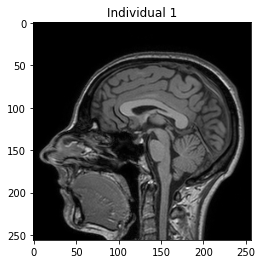

In [13]:
# # Plot sagittal image of first individual
# f = h5py.File(file_path, "r")
# dset = f['mri']
# plt.imshow(dset[0][64].reshape(256,256), cmap="gray", animated=True)
# plt.title("Individual 1")
# plt.show()
# f.close()

In [17]:
# from itkwidgets import view
# f = h5py.File(file_path, "r")
# dset = f['mri']
# view(dset[0][64])

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itkImagePython.itkImageD2; proxy o…

In [14]:
# # Show the number of individuals or lenght of file
# f = h5py.File(file_path, "r")
# dset = f['mri']
# print("There are %d individuals." % dset.len())
# f.close()

There are 581 individuals.


In [16]:
print("There are %d individuals." % len(individuals))

There are 581 individuals.


# Autoencoder creation: The Convolutional Autoencoder.

A first autoencoder is created

In [0]:
# Autoencoder is created
# Reference:
# https://www.datacamp.com/community/tutorials/reconstructing-brain-images-deep-learning

inChannel = 1
# x, y = 256, 320
x, y = 256, 256
input_img = Input(shape = (x, y, inChannel))

def autoencoder(input_img):
    #encoder
    #input = 256 x 256 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #256 x 256 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #128 x 128 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #128 x 128 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #64 x 64 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #64 x 64 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)

    #decoder
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3) #64 x 64 x 128
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    up1 = UpSampling2D((2,2))(conv4) # 128 x 128 x 128
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 128 x 128 x 64
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    up2 = UpSampling2D((2,2))(conv5) # 256 x 256 x 64
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 256 x 256 x 1
    return decoded

In [17]:
inChannel = 1
# x, y = 256, 320
x, y = 256, 256
input_img = Input(shape = (x, y, inChannel))

def autoencoder(input_img):
    #encoder
    #input = 256 x 256 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #256 x 256 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3) #7 x 7 x 128 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #7 x 7 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    up1 = UpSampling2D((2,2))(conv5) # 14 x 14 x 128
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) #7 x 7 x 128
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up2 = UpSampling2D((2,2))(conv6) # 14 x 14 x 128
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2) # 14 x 14 x 64
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up3 = UpSampling2D((2,2))(conv7) # 28 x 28 x 64
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up3) # 28 x 28 x 1
    return decoded

In [114]:
inChannel = 1
# x, y = 256, 320
x, y = 256, 256
input_img = Input(shape = (x, y, inChannel))

def autoencoder(input_img):
    #encoder
    #input = 256 x 256 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #256 x 256 x 32
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #128 x 128 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #128 x 128 x 64
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #64 x 64 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #64 x 64 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3) #32 x 32 x 128 (small and thick)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3) #32 x 32 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #32 x 32 x 256
    conv5 = BatchNormalization()(conv5)
    up1 = UpSampling2D((2,2))(conv5) # 64 x 64 x 256
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) #64 x 64 x 128
    conv6 = BatchNormalization()(conv6)
    up2 = UpSampling2D((2,2))(conv6) # 128 x 128 x 128
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2) # 128 x 128 x 64
    conv7 = BatchNormalization()(conv7)
    up3 = UpSampling2D((2,2))(conv7) # 256 x 256 x 64    
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up3) # 256 x 256 x 1
    return decoded

In [18]:
# Compilation
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop(learning_rate=1e-03, clipnorm=1.0))
#autoencoder.compile(loss='mean_squared_error', optimizer = Adam())
#, metrics=['accuracy']
#autoencoder.compile(loss='binary_crossentropy', optimizer='adadelta')

In [19]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      18496 

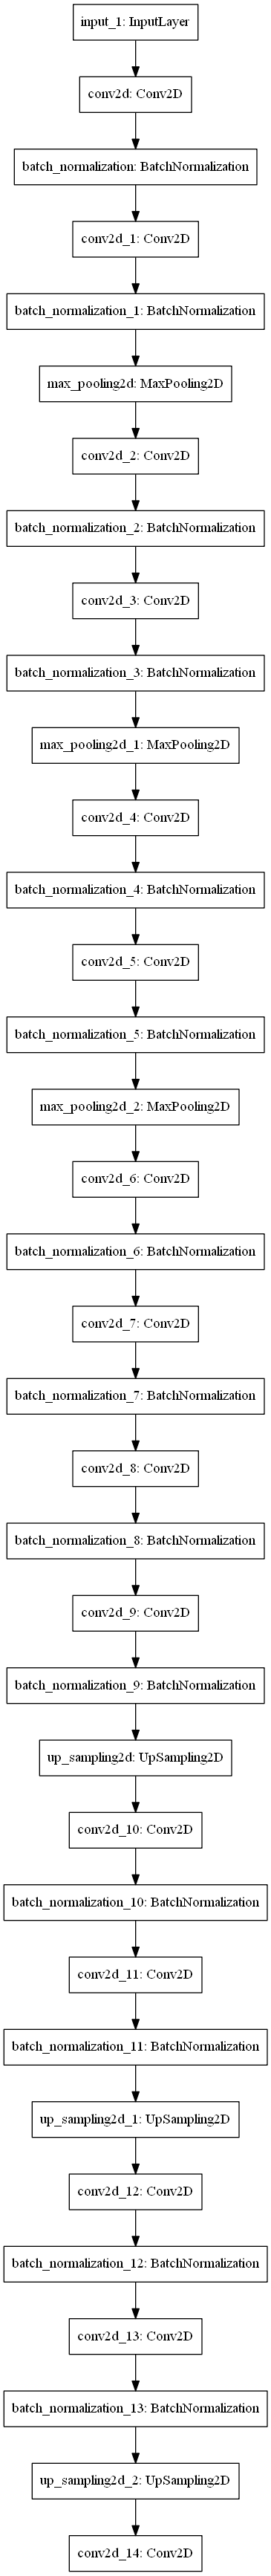

In [20]:
from tensorflow.keras.utils import plot_model
plot_model(autoencoder)

# Creation of train and validation generators

In order to train the model with a large dataset is required to used fit_generator with train and validation generators

In [19]:
# mri_h5py_path = file_path

In [20]:
# with h5py.File(mri_h5py_path, "r") as mri_data:
#     dset = mri_data["mri"]
#     B=dset[2,::]
#     print(np.max(B))
# #     print(B.shape)
# #     X=B[1:1+32,::]
# #     X = np.asarray(X)
# #     X = X.reshape(-1,256,256,1)    
# #     print(X.shape)

1.0


In [21]:
# import gc

NUM_EPOCHS=300

In [22]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [23]:
#logs_path="/content/drive/My Drive/TFM/TFM_Files/0305-Autoencoder_Large_Dataset_Adam/logs/"
logs_path=".\\logs\\"

In [24]:
import datetime
log_dir = logs_path + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") +"\\"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=5, write_graph=True, write_images=True,
                                                      update_freq='epoch', profile_batch=2, embeddings_freq=1)

In [25]:
SEED = 7
np.random.seed(SEED)
validation_ratio=0.2
sample_count = len(individuals)
sample_idxs = range(0, sample_count)
sample_idxs = np.random.permutation(sample_idxs)
training_sample_idxs = sample_idxs[0:int((1-validation_ratio)*sample_count)]
validation_sample_idxs = sample_idxs[int((1-validation_ratio)*sample_count):]

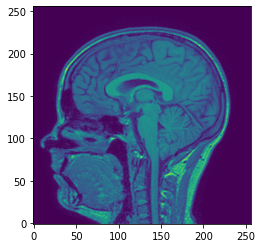

In [26]:
i = 1
B = sitk.ReadImage(individuals[training_sample_idxs[i]])
img_arr = sitk.GetArrayFromImage(B)[75]
plt.imshow(img_arr, origin="lower")
plt.show()

In [27]:
sitk.GetArrayFromImage(B).shape

(150, 256, 256)

In [28]:
phi = 15
theta = 15
psi = 15
rotated_B =  rotation3d(B, phi, theta, psi)

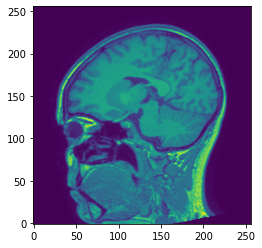

In [29]:
img_arr = sitk.GetArrayFromImage(rotated_B)[75]
plt.imshow(img_arr, origin="lower")
plt.show()

In [30]:
rot_B_arr=sitk.GetArrayFromImage(rotated_B)
print(rot_B_arr.shape)

(150, 256, 256)


In [31]:
Z = np.zeros(shape=(32,rot_B_arr.shape[1],rot_B_arr.shape[2]), dtype=rot_B_arr.dtype)
Z.shape

(32, 256, 256)

In [32]:
batch_size = 32
print(rot_B_arr.shape)
for j in range(0,rot_B_arr.shape[0]-1,batch_size):    
    k = j+batch_size if j+batch_size<=rot_B_arr.shape[0] else rot_B_arr.shape[0]
    print(j, k)
    print(rot_B_arr[j:k,::].shape)

(150, 256, 256)
0 32
(32, 256, 256)
32 64
(32, 256, 256)
64 96
(32, 256, 256)
96 128
(32, 256, 256)
128 150
(22, 256, 256)


In [33]:
Z = np.zeros(shape=(32,rot_B_arr.shape[1],rot_B_arr.shape[2]), dtype=rot_B_arr.dtype)
Z.shape

(32, 256, 256)

In [34]:
k=22
Z[:k,::]=rot_B_arr[128:150,::]

In [107]:
from tqdm import tqdm
MAX = 0
MIN = 0
for i in tqdm(individuals):
    ind = sitk.ReadImage(i)
    arr = sitk.GetArrayFromImage(ind)
    MAX = max(MAX,np.max(arr))
    MIN = min(MIN,np.min(arr))
print("MAX: ", MAX)    
print("MIN: ", MIN)

100%|██████████| 581/581 [01:42<00:00,  5.67it/s]


MAX:  16790
MIN:  0


In [108]:
MAX = 0 
MIN = 0
ind = sitk.ReadImage(individuals[1])
arr = sitk.GetArrayFromImage(ind)
MAX = max(MAX,np.max(arr))
MIN = min(MIN,np.min(arr))
print("MAX: ", MAX)    
print("MIN: ", MIN)

MAX:  3996.7488
MIN:  0


In [35]:
# Reference:
# https://riptutorial.com/keras/example/29807/training-a-model-to-classify-videos
def generate_training_sequences(batch_size, mri_paths, training_sample_idxs, angles):
    """ Generates training sequences on demand
    """
    while True:
        
        for i in range(0, len(training_sample_idxs)):
            ind = sitk.ReadImage(mri_paths[training_sample_idxs[i]])
            for phi in angles:
                for theta in angles:
                    for psi in angles:
                        rot_ind = rotation3d(ind, phi, theta, psi)
                        rot_ind_arr = sitk.GetArrayFromImage(rot_ind)
                        mx = np.max(rot_ind_arr)
                        mn = np.min(rot_ind_arr)
                        rot_ind_arr = (rot_ind_arr - mn)/(mx - mn)                        
                        for j in range(0,rot_ind_arr.shape[0],batch_size):
                            k = j+batch_size if j+batch_size<=rot_B_arr.shape[0] else rot_B_arr.shape[0]                            
                            X=np.zeros(shape=(batch_size,rot_B_arr.shape[1],rot_B_arr.shape[2]),
                                       dtype=rot_B_arr.dtype)
                            X[:rot_ind_arr[j:k,::].shape[0],::]=rot_ind_arr[j:k,::]
                            X=np.asarray(X)
                            X=X.reshape(-1,256,256,1)
                            yield X, X
                
            
def generate_validation_sequences(batch_size, mri_paths, validation_sample_idxs, angles):
    """ Generates validation sequences on demand
    """
    while True:

        for i in range(0, len(validation_sample_idxs)):
            ind = sitk.ReadImage(mri_paths[validation_sample_idxs[i]])
            for phi in angles:
                for theta in angles:
                    for psi in angles:
                        rot_ind = rotation3d(ind, phi, theta, psi)
                        rot_ind_arr = sitk.GetArrayFromImage(rot_ind)  
                        mx = np.max(rot_ind_arr)
                        mn = np.min(rot_ind_arr)
                        rot_ind_arr = (rot_ind_arr - mn)/(mx - mn)                         
                        for j in range(0,rot_ind_arr.shape[0],batch_size):
                            k = j+batch_size if j+batch_size<=rot_B_arr.shape[0] else rot_B_arr.shape[0]                            
                            X=np.zeros(shape=(batch_size,rot_B_arr.shape[1],rot_B_arr.shape[2]),
                                       dtype=rot_B_arr.dtype)
                            X[:rot_ind_arr[j:k,::].shape[0],::]=rot_ind_arr[j:k,::]
                            X=np.asarray(X)
                            X=X.reshape(-1,256,256,1)
                            yield X, X        


In [36]:
def train_model(model, mri_paths, validation_ratio=0.2, batch_size=1, angles=[0]):
    """ Train the autoencoder model
    """
      
    sample_count = len(mri_paths)
    sample_idxs = range(0, sample_count)
    sample_idxs = np.random.permutation(sample_idxs)
    training_sample_idxs = sample_idxs[0:int((1-validation_ratio)*sample_count)]
    validation_sample_idxs = sample_idxs[int((1-validation_ratio)*sample_count):]
    training_sequence_generator = generate_training_sequences(batch_size=batch_size,
                                                              mri_paths=mri_paths,
                                                              training_sample_idxs=training_sample_idxs,
                                                              angles=angles)
    validation_sequence_generator = generate_validation_sequences(batch_size=batch_size,
                                                                  mri_paths=mri_paths,
                                                                  validation_sample_idxs=validation_sample_idxs,
                                                                  angles=angles)
    history = model.fit(training_sequence_generator,
                        validation_data=validation_sequence_generator,
                         #samples_per_epoch=len(training_sample_idxs),
                         #nb_val_samples=len(validation_sample_idxs),
                        steps_per_epoch=len(training_sample_idxs),
                        validation_steps=len(validation_sample_idxs),
                        epochs=NUM_EPOCHS,
                        #max_q_size=1,
                        verbose=1,
                        class_weight=None,
                        callbacks =[tensorboard_callback])
                         #nb_worker=1)
    return history
        

In [37]:
h = train_model(autoencoder, mri_paths=individuals, batch_size=16, angles=[-15, 0, 15])

Epoch 1/300
464/464 [==============================] - 86s 186ms/step - loss: 0.0261 - val_loss: 0.0109
Epoch 2/300
464/464 [==============================] - 84s 181ms/step - loss: 0.0103 - val_loss: 0.0934
Epoch 3/300
464/464 [==============================] - 87s 186ms/step - loss: 0.0037 - val_loss: 0.0110
Epoch 4/300
464/464 [==============================] - 86s 185ms/step - loss: 0.0032 - val_loss: 0.0093
Epoch 5/300
464/464 [==============================] - 87s 188ms/step - loss: 0.0020 - val_loss: 0.0055
Epoch 6/300
464/464 [==============================] - 86s 186ms/step - loss: 0.0017 - val_loss: 0.0062
Epoch 7/300
464/464 [==============================] - 86s 185ms/step - loss: 0.0014 - val_loss: 0.0051
Epoch 8/300
464/464 [==============================] - 84s 181ms/step - loss: 0.0017 - val_loss: 0.0028
Epoch 9/300
464/464 [==============================] - 86s 185ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 10/300
464/464 [==============================] - 85s 184m

464/464 [==============================] - 85s 183ms/step - loss: 5.1867e-04 - val_loss: 6.8321e-04
Epoch 77/300
464/464 [==============================] - 84s 181ms/step - loss: 7.5552e-04 - val_loss: 3.7428e-04
Epoch 78/300
464/464 [==============================] - 84s 182ms/step - loss: 6.3203e-04 - val_loss: 0.0034
Epoch 79/300
464/464 [==============================] - 85s 183ms/step - loss: 6.3974e-04 - val_loss: 0.0022
Epoch 80/300
464/464 [==============================] - 85s 183ms/step - loss: 4.8989e-04 - val_loss: 0.0012
Epoch 81/300
464/464 [==============================] - 85s 183ms/step - loss: 3.8565e-04 - val_loss: 0.0049
Epoch 82/300
464/464 [==============================] - 84s 180ms/step - loss: 6.5530e-04 - val_loss: 5.9285e-04
Epoch 83/300
464/464 [==============================] - 85s 184ms/step - loss: 7.0790e-04 - val_loss: 6.3031e-04
Epoch 84/300
464/464 [==============================] - 85s 182ms/step - loss: 5.9296e-04 - val_loss: 0.0082
Epoch 85/300
464

464/464 [==============================] - 87s 188ms/step - loss: 2.3740e-04 - val_loss: 0.0013
Epoch 222/300
464/464 [==============================] - 87s 186ms/step - loss: 1.7399e-04 - val_loss: 0.0013
Epoch 223/300
464/464 [==============================] - 86s 185ms/step - loss: 4.5457e-04 - val_loss: 4.5697e-04
Epoch 224/300
464/464 [==============================] - 86s 185ms/step - loss: 3.5007e-04 - val_loss: 2.9329e-04 loss:
Epoch 225/300
464/464 [==============================] - 86s 185ms/step - loss: 5.0030e-04 - val_loss: 3.6963e-04
Epoch 226/300
464/464 [==============================] - 86s 185ms/step - loss: 3.8147e-04 - val_loss: 5.2370e-04
Epoch 227/300
464/464 [==============================] - 85s 184ms/step - loss: 3.3846e-04 - val_loss: 3.8851e-04
Epoch 228/300
464/464 [==============================] - 86s 185ms/step - loss: 3.6501e-04 - val_loss: 0.0022
Epoch 229/300
464/464 [==============================] - 86s 185ms/step - loss: 1.9907e-04 - val_loss: 3.747

In [9]:
#$ from jupyter notebook
# Reference:
# https://stackoverflow.com/questions/33836728/view-tensorboard-on-docker-on-google-cloud?noredirect=1

ps = !ps -ax
is_tensorboard_running = len([f for f in ps if "tensorboard" in f ]) > 0
print(is_tensorboard_running)

is_ngrok_running = len([f for f in ps if "ngrok" in f ]) > 0
print("tensorbord={}, ngrok={}".format(is_tensorboard_running, is_ngrok_running))

if not is_ngrok_running:  
#    grok should be installed in /content/ngrok
  get_ipython().system_raw('/content/ngrok http 6006 &')
  is_ngrok_running = True

# get public url for tensorboard
tensorboard_url = !curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"    
print("tensorboard url=", tensorboard_url)


True
tensorbord=True, ngrok=False
tensorboard url= ['Traceback (most recent call last):', '  File "<string>", line 1, in <module>', '  File "/usr/lib/python3.6/json/__init__.py", line 299, in load', '    parse_constant=parse_constant, object_pairs_hook=object_pairs_hook, **kw)', '  File "/usr/lib/python3.6/json/__init__.py", line 354, in loads', '    return _default_decoder.decode(s)', '  File "/usr/lib/python3.6/json/decoder.py", line 339, in decode', '    obj, end = self.raw_decode(s, idx=_w(s, 0).end())', '  File "/usr/lib/python3.6/json/decoder.py", line 357, in raw_decode', '    raise JSONDecodeError("Expecting value", s, err.value) from None', 'json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)']


In [24]:
logs_path

'.\\logs\\'

In [38]:
%tensorboard --logdir ".\\logs"

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 21636.

In [39]:
h.history.keys()

dict_keys(['loss', 'val_loss'])

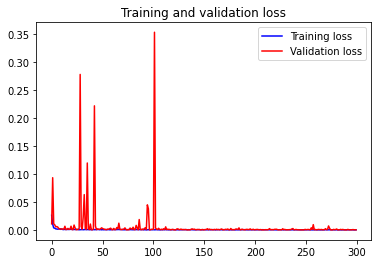

In [40]:
loss = h.history['loss']
val_loss = h.history['val_loss']
epochs = range(NUM_EPOCHS)
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
# loss = h.history['accuracy']
# val_loss = h.history['val_accuracy']
# epochs = range(NUM_EPOCHS)
# plt.figure()
# plt.plot(epochs, loss, 'b', label='Training loss')
# plt.plot(epochs, val_loss, 'r', label='Validation loss')
# plt.title('Training and validation loss')
# plt.legend()
# plt.show()

In [41]:
# String with timestamp
from datetime import datetime
datetime = datetime.now().strftime('%Y%m%d%H%M%S')
print(datetime)

20200518143753


In [0]:
# #path = "/content/drive/My Drive/TFM/TFM_Files/0304-Autoencoder_Large_Dataset_RMSProp/"
# path ="/content/drive/My Drive/TFM/TFM_Files/0305-Autoencoder_Large_Dataset_Adam/"
# datetime= "20200427233001"

In [42]:
path = ".\\"
datetime = "20200518143753"

In [43]:
# Reference
# https://machinelearningmastery.com/save-load-keras-deep-learning-models/
# Serialize model to JSON
autoencoder_json = autoencoder.to_json()
with open(path + 'ae_adam_' + datetime + '.json', "w") as json_file:
    json_file.write(autoencoder_json)
# Serialize weights to HDF5
autoencoder_saved = autoencoder.save_weights(path + 'ae_adam_mri_' + datetime +'.h5')
print("Saved model to disk")

Saved model to disk


# Predicting on Validation Data

In [44]:
# load json and create model
from tensorflow.keras.models import model_from_json
json_file = open(path + "ae_adam_" + datetime+ ".json", "r")
loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)
json_file.close()
loaded_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      18496 

In [45]:
# load weights into new model
loaded_model.load_weights(path + "ae_adam_mri_" + datetime + ".h5")

In [47]:
mri_h5py_path="../IXI-T1-H5PY/mri.hdf5"

In [48]:
# TODO: Train and validate with part of the set and validate with other samples
TEST_SIZE=5
V_WIDTH=130
NUM_SLICES=20
MIN=V_WIDTH//2-NUM_SLICES
MAX=V_WIDTH//2+NUM_SLICES
valid_X = []
with h5py.File(mri_h5py_path, "r") as mri_data:
    dset = mri_data["mri"]           
    sample_count = dset.len()
    sample_idxs = range(0, sample_count)
    sample_idxs = np.random.permutation(sample_idxs)
    validation_sample_idxs = sample_idxs[-TEST_SIZE:]
    for index in validation_sample_idxs:
        X = dset[index,::]
        X = X[MIN:MAX,::]
        X.reshape(-1,256,256,1)
        valid_X.append(X)
        

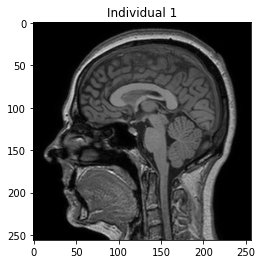

In [50]:
plt.imshow(valid_X[0][20].reshape(256,256), cmap="gray", animated=True)
plt.title("Individual 1")
plt.show()
#f.close()

In [54]:
predictions = []
for elem in valid_X:
    pred = loaded_model.predict(elem.reshape(-1,256,256,1))
    predictions.append(pred)

In [51]:
predictions = []
for elem in valid_X:
    pred = autoencoder.predict(elem.reshape(-1,256,256,1))
    predictions.append(pred)

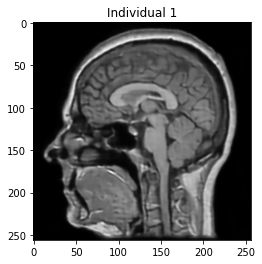

NameError: name 'f' is not defined

In [52]:
plt.imshow(predictions[0][20].reshape(256,256), cmap="gray", animated=True)
plt.title("Individual 1")
plt.show()
#f.close()

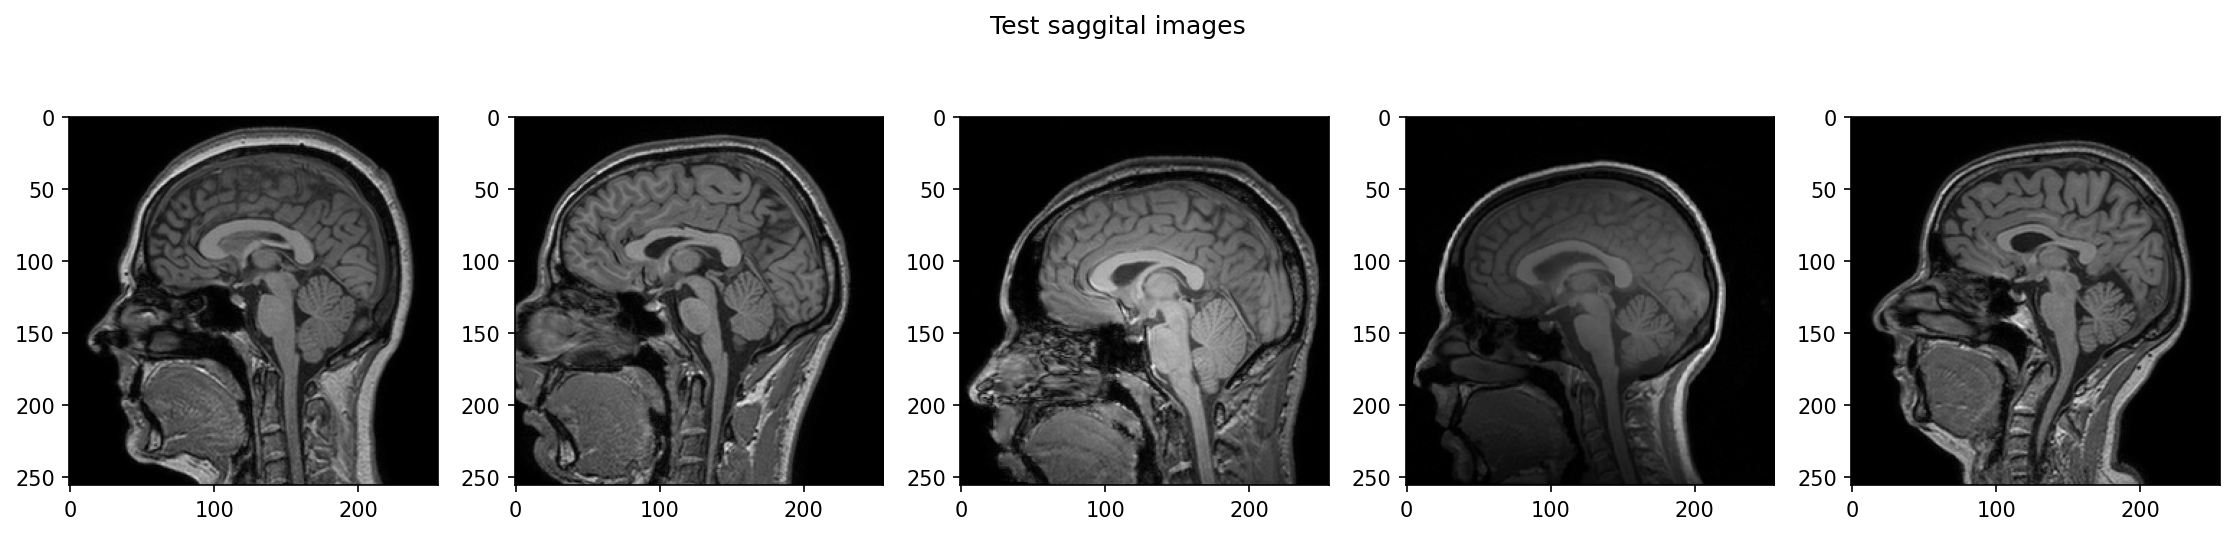

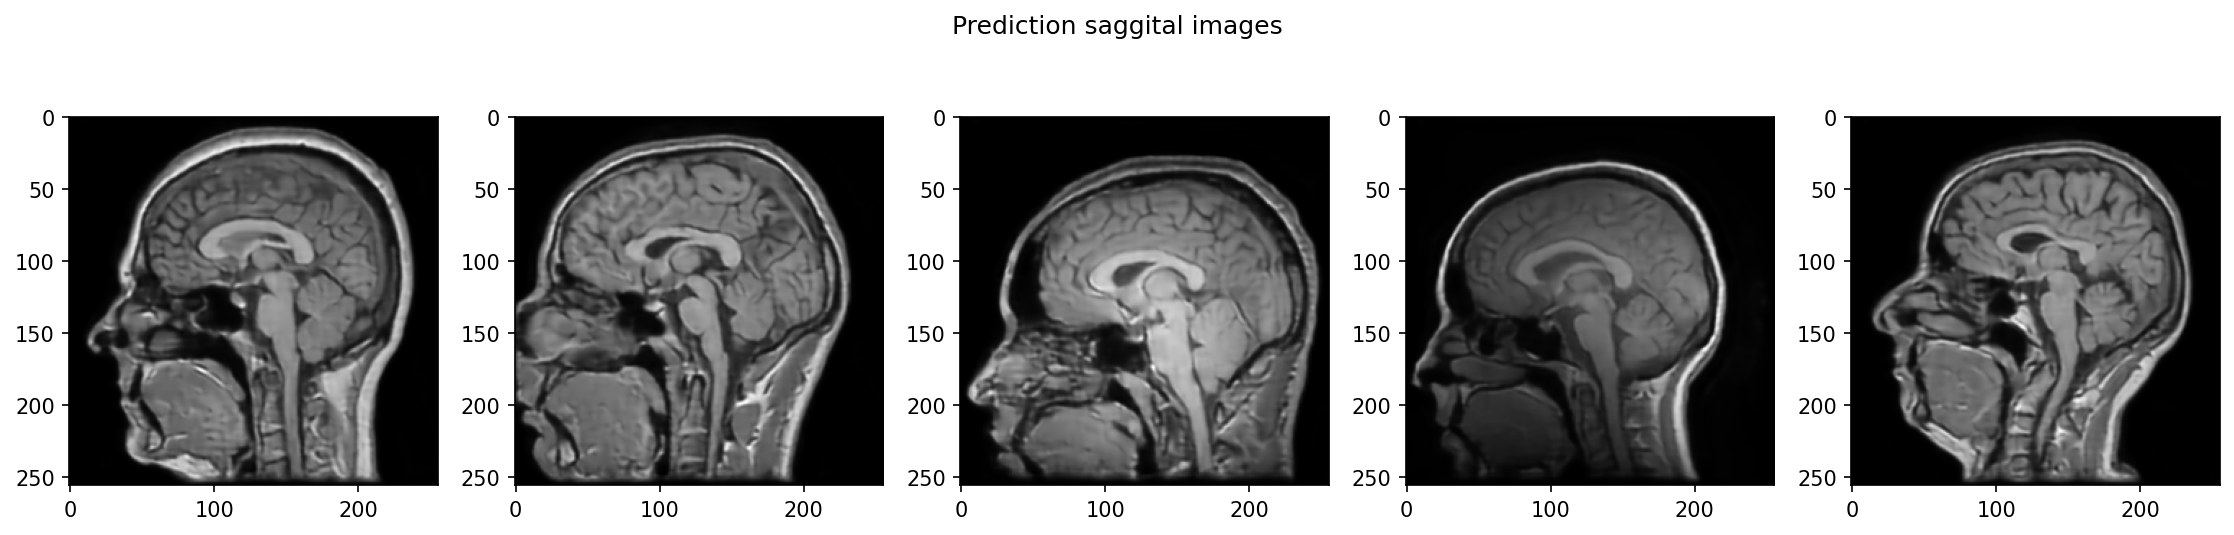

In [53]:
# Representing the figures
FIGS_PER_LINE=5
MIDDLE = 20
fig_x = 15
fig_y = 8
fig1 = plt.figure(figsize=(fig_x,fig_y), dpi=150)
fig1.suptitle('Test saggital images')
for i, j in zip(range(len(valid_X)),range(1,len(valid_X)+1)):
    ax = fig1.add_subplot(len(valid_X)//FIGS_PER_LINE + 1, FIGS_PER_LINE, j) 
    #ax.annotate("Individual %d" % j,(3,3),bbox={'facecolor':'white'},fontsize=16)
    #ax.annotate(individuals[i][9:-7],(3,3),bbox={'facecolor':'white'},fontsize=14)
    plt.imshow(valid_X[i][MIDDLE].reshape(256,256), cmap="gray")
plt.tight_layout()
#plt.savefig('IXI-T1.png', dpi=150)
fig2 = plt.figure(figsize=(fig_x,fig_y), dpi=150)
fig2.suptitle('Prediction saggital images')
for i, j in zip(range(len(predictions)),range(1,len(predictions)+1)):
    ax = fig2.add_subplot(len(predictions)//FIGS_PER_LINE + 1, FIGS_PER_LINE, j) 
    #ax.annotate("Individual %d" % j,(3,3),bbox={'facecolor':'white'},fontsize=16)
    #ax.annotate(individuals[i][9:-7],(3,3),bbox={'facecolor':'white'},fontsize=14)
    plt.imshow(predictions[i][MIDDLE].reshape(256,256), cmap="gray")
plt.tight_layout()
plt.savefig('Test and predictions.png', dpi=150)
plt.show()


In [54]:
# Test with noisy images
[a,b,c]= np.shape(valid_X[0])
mean = 0
sigma = 0.05
gauss = np.random.normal(mean,sigma,(a,b,c))
noisy_images = []
for elem in valid_X:
    noisy_images.append(elem + gauss)

In [55]:
pred_noisy = []
for elem in noisy_images:
    pred = loaded_model.predict(elem.reshape(-1,256,256,1))
    pred_noisy.append(pred)

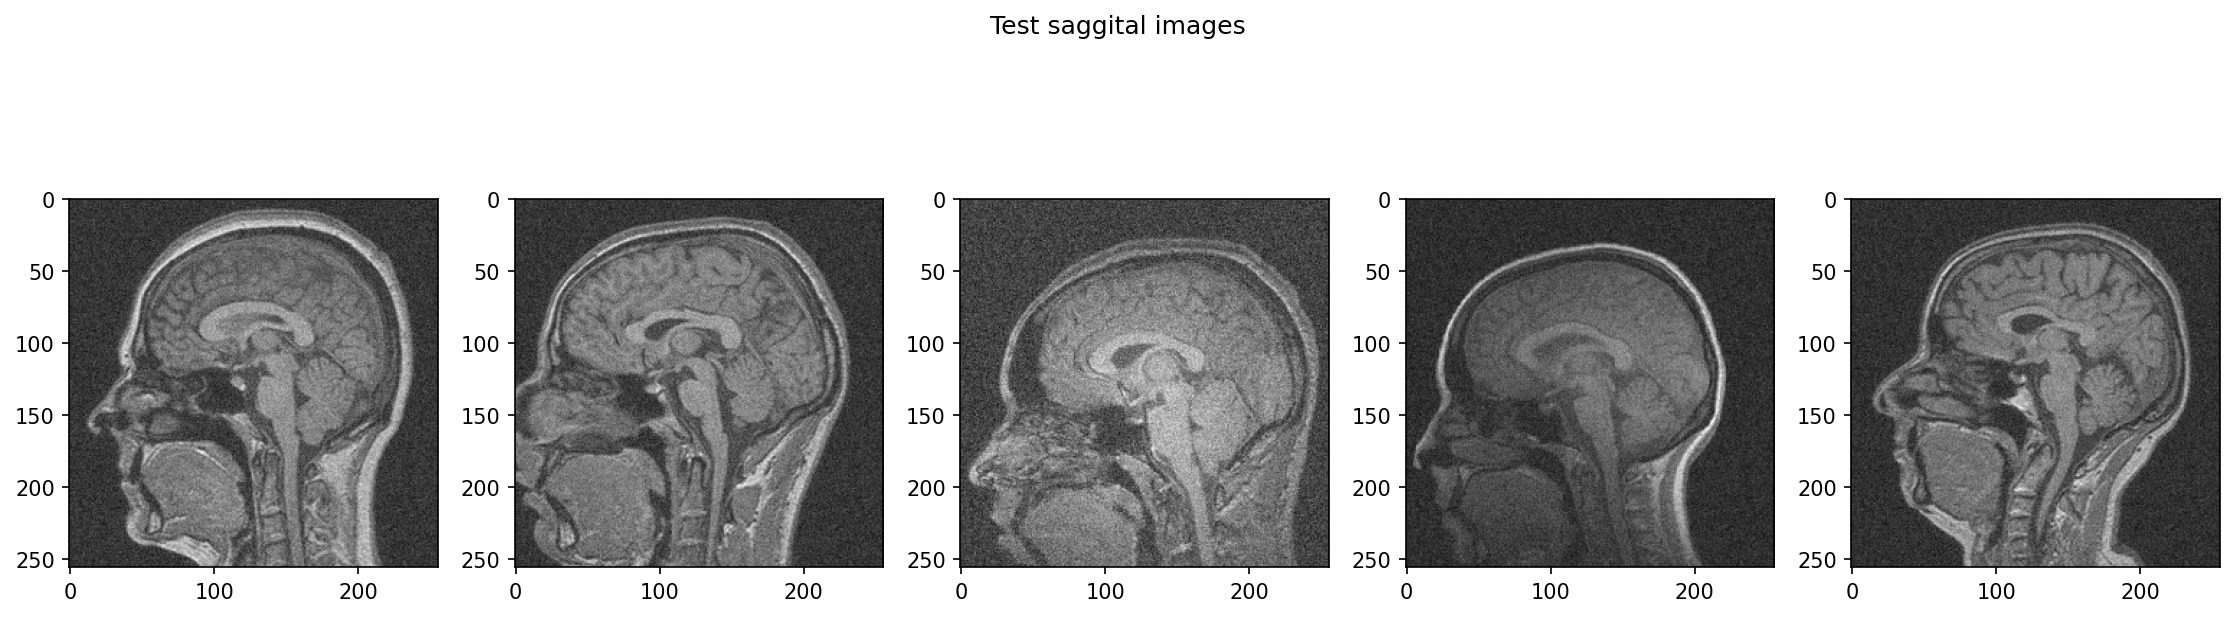

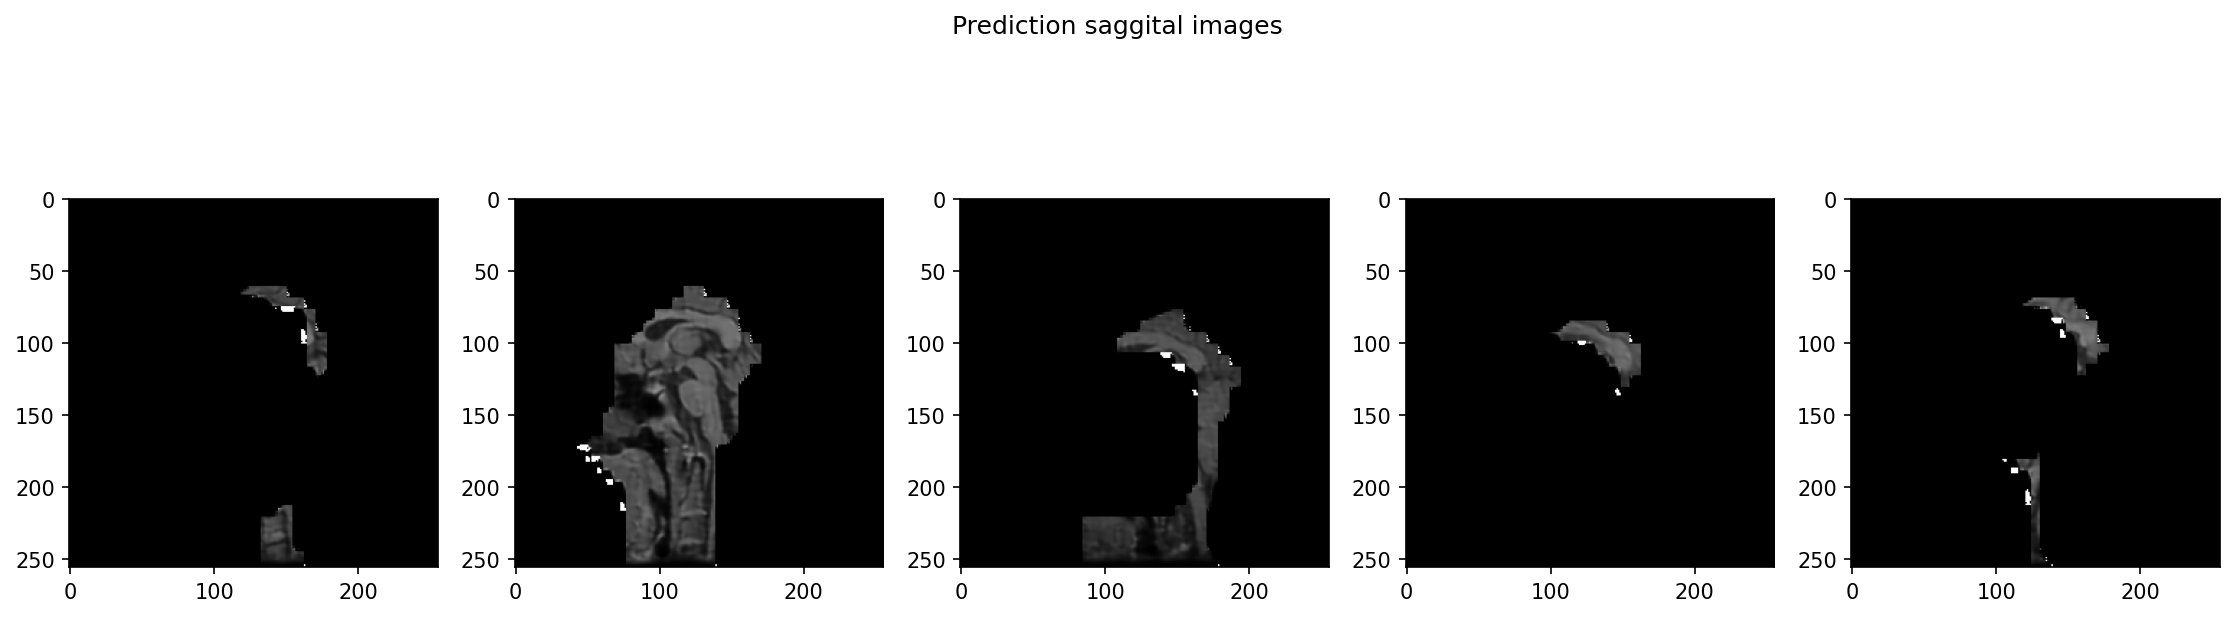

In [56]:
# Representing the figures
FIGS_PER_LINE=5
MIDDLE = 20
fig_x = 15
fig_y = 10
fig1 = plt.figure(figsize=(fig_x,fig_y), dpi=150)
fig1.suptitle('Test saggital images')
for i, j in zip(range(len(noisy_images)),range(1,len(noisy_images)+1)):
    ax = fig1.add_subplot(len(noisy_images)//FIGS_PER_LINE + 1, FIGS_PER_LINE, j) 
    #ax.annotate("Individual %d" % j,(3,3),bbox={'facecolor':'white'},fontsize=16)
    #ax.annotate(individuals[i][9:-7],(3,3),bbox={'facecolor':'white'},fontsize=14)
    plt.imshow(noisy_images[i][MIDDLE].reshape(256,256), cmap="gray")
plt.tight_layout()
#plt.savefig('IXI-T1.png', dpi=150)
fig2 = plt.figure(figsize=(fig_x,fig_y), dpi=150)
fig2.suptitle('Prediction saggital images')
for i, j in zip(range(len(pred_noisy)),range(1,len(pred_noisy)+1)):
    ax = fig2.add_subplot(len(pred_noisy)//FIGS_PER_LINE + 1, FIGS_PER_LINE, j) 
    #ax.annotate("Individual %d" % j,(3,3),bbox={'facecolor':'white'},fontsize=16)
    #ax.annotate(individuals[i][9:-7],(3,3),bbox={'facecolor':'white'},fontsize=14)
    plt.imshow(pred_noisy[i][MIDDLE].reshape(256,256), cmap="gray")
plt.tight_layout()
plt.savefig('Test noisy and predictions.png', dpi=150)
plt.show()

# Quantitative Metric: Peak Signal-to-Noise Ratio (PSNR)

In [57]:
#valid_pred = autoencoder.predict(valid_X)
mse =  np.mean((np.asarray(valid_X).reshape(-1,40,256,256) - np.asarray(predictions).reshape(-1,40,256,256)) ** 2)
psnr = 20 * math.log10( 1.0 / math.sqrt(mse))

In [58]:
print('PSNR of reconstructed validation images: {psnr}dB'.format(psnr=np.round(psnr,2)))

PSNR of reconstructed validation images: 29.54dB


In [59]:
#noisy_pred = autoencoder.predict(noisy_images)
#mse =  np.mean((valid_X - noisy_pred) ** 2)
mse =  np.mean((np.asarray(valid_X).reshape(-1,40,256,256) - np.asarray(pred_noisy).reshape(-1,40,256,256)) ** 2)
psnr_noisy = 20 * math.log10( 1.0 / math.sqrt(mse))

In [60]:
print('PSNR of reconstructed validation images: {psnr}dB'.format(psnr=np.round(psnr_noisy,2)))

PSNR of reconstructed validation images: 13.9dB


Comparing with first autoencoder sample trained with 40 samples and 300 epochs it could be said that is more important the number of epochs that is trained than the sample size. 
TO DO: It is required to train with more epochs the model and compare results. The training time can be around 44 hours.

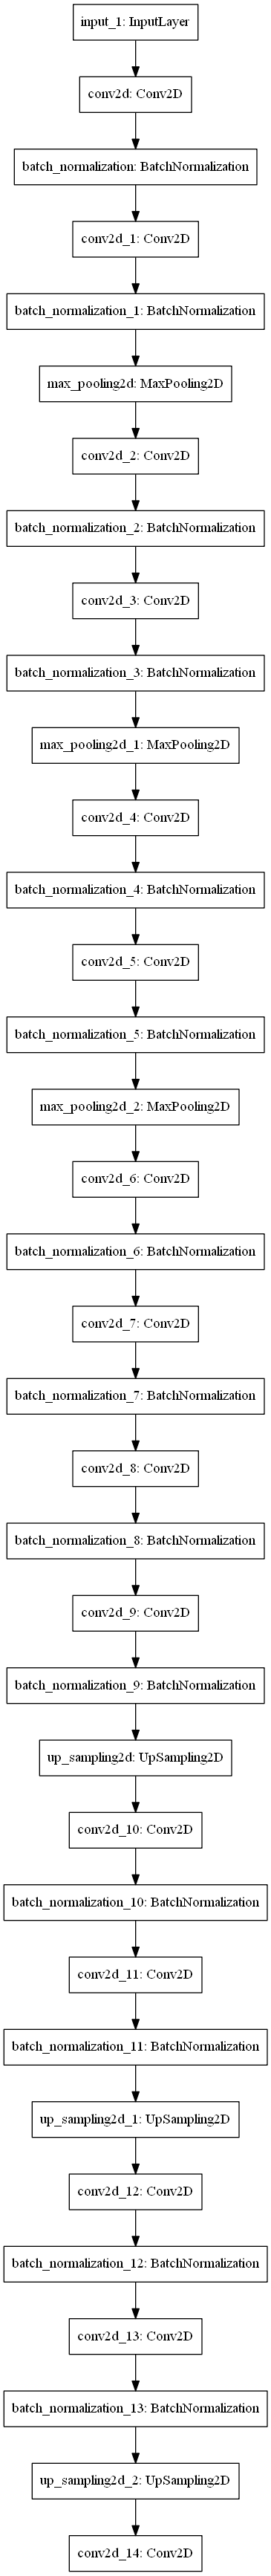

In [61]:
from tensorflow.keras.utils import plot_model
plot_model(loaded_model)